<a href="https://colab.research.google.com/github/TaviTragus/data-science-fundamentals/blob/main/Unit6/Copy_of_Unit6ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#hide

In [1]:
!pip install git+https://github.com/pydata/xarray.git

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-wk4vrn74
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-wk4vrn74
  Resolved https://github.com/pydata/xarray.git to commit 6bea71572120c0eef2e4bf8d269d32b17a39dc35
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.2.dev3+g6bea7157-py3-none-any.whl size=1244326 sha256=10b82ea6303432482255abb3182169fd07278fb9686a2e87a0fa9050990fc036
  Stored in directory: /tmp/pip-ephem-wheel-cache-yth48rsg/wheels/3a/ec/c0/1cda725917279b6beba2a020d6ccddfee2176b25648f4fcad8
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2024.11.0
    Uninstalling xarray-2024.11.0:
      Successfully uninstalled xarray-2024.11.0


In [2]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.4 MB/s eta 0:00:00


In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import bambi as bmb

# Unit 6 Exercises: Is my model good?

#### Over and Under fitting, Model Visualization, and Model/Variable Selection Concepts

These exercises are meant to get you to think about the model and variable selection process, and consider how we determine if a model is "good".

##**Task1**:


Does elpd_loo mean anything if we only have one model?

ELPD_loo doesn't mean anything if we only have one model. Its only useful when comparing two similar models.

##**Task2**:

Describe overfitting, in the context of this course

I am pretty sure that overfitting is when we use too much specification, or make a model that very closely predicts our dataset (like the height-weight predictions from last unit). Its very accurate for one specific group of people, but is probably too specific to model height and weight of the general population.

##**Task3**:

How do we mitigate overfitting?

We can mitigate overfitting by using as few variables as possible. We also use weak priors/regulizing priors to prevent overfitting.

##**Task4**:

How do we mitigate underfitting?

We mitigate underfitting by comparing the elpd_loo values of our models. We want a more positive elpd_loo value (greater?).

##**Task5**:

Why would we want more than one predictor in a model?

\Using multiple predictors can be more powerful. It will give you a more accurate picture of reality. It can aso be trickier to make.

##**Task6**:

Can we have too many predictors? How would we now?

Yes. Too many predictors can lead to overfitting.

##**Task7**:

What is variable selection, and how does it work?

We use the causal diagram and and elpd_loo values to select which variables will helpful for making our prediction. There is also something called Kulprit but we don't know how that works/it isn't updated or released rn.

##**Task8**:

Describe the differences and similarities between the following three models: linear regression with two predictors, one of which is a categorical variable:

- adding the variables in the model, as is standard.
- using that categorical variable as a hierarchy upon the other predictor variable.
- adding the variables, plus the categorical variable's interaction with the other variable

##**Task9**:

How do we visualize multiple linear regression models? Can we visualize the entire model, all at once?

There are different methods. With the bycicles rented model, we displayed every hour as its own graph. In basketball, we split each position into different colors. We usually can't visualize the whole model at once because it can get really complicated, especially when we only have two dimensions to work with. See the last graph in the notes.

##**Task10**:

Compare the following linear models that all use the basketball data to predict field goal percentage:

- predictors free throw percentage and position (with position as a categorical predictor)
- predictors free throw percentage and position (with position as a hierarchy)
- predictors free throw percentage and position (with position interacting with frew throw percentage)
- predictors free throw percentage, position, 3 point attempts, and interactions between all three predictors
- predictors free throw percentage, position, 3 point attempts, with an interaction between 3 point attempts and postion.

using ```az.compare()``` and ```az.plot_compare()```, or an equivalent method using LOO (elpd_loo).

###Set up

cleaning data

In [4]:
#have to drop incomplete rows, so that bambi will run
bb = pd.read_csv(
    'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv').dropna()

In [5]:
#only look at players who played more than 600 minutes
#which is 20 min per game, for 30 games
bb = bb.query('MP > 600')
#remove players who never missed a free throw
bb = bb.query('`FT%` != 1.0')
#filter out the combo positions. This will make it easier to read the graphs
bb = bb.query("Pos in ['C','PF','SF','SG','PG']")
#gets rid of the annoying '%' sign
bb.rename(columns={"FT%":"FTp","FG%":"FGp","3P%":"3Pp"}, inplace=True)

In [6]:
bb

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FGp,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
5,Grayson Allen,SG,28,PHO,75,74,2513,340,682,0.499,...,48,247,295,227,69,45,95,157,1014,allengr01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,Jalen Wilson,PF,23,BRK,43,3,664,76,179,0.425,...,47,84,131,45,11,4,19,48,214,wilsoja03
563,James Wiseman,C,22,DET,63,6,1091,187,305,0.613,...,110,226,336,54,12,39,66,141,446,wisemja01
565,Christian Wood,PF,28,LAL,50,1,872,123,264,0.466,...,39,215,254,49,16,33,50,72,347,woodch01
566,Delon Wright,PG,31,TOT,47,1,742,74,188,0.394,...,19,67,86,119,54,11,14,32,210,wrighde01


###predictors free throw percentage and position (with position as a categorical predictor)

In [7]:
#define the model
model_basketball = bmb.Model("`FGp` ~ `FTp` + Pos", data=bb)
#fit the model
idata_basketball = model_basketball.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FTp', ylabel='FGp'>], dtype=object))

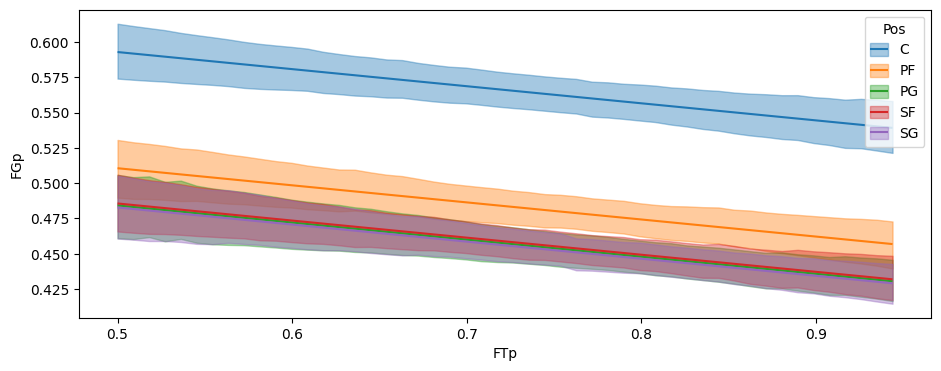

In [8]:
#plot 94% HDIs of the means of each position
bmb.interpret.plot_predictions(model_basketball,
                               idata_basketball,
                                ["FTp",  "Pos"], fig_kwargs={"figsize":(11, 4)})

###predictors free throw percentage and position (with position as a hierarchy)

In [9]:
#define the model, but as a hierarchy
model_basketball_h = bmb.Model("`FGp` ~ (`FTp`|Pos)", data=bb)
#create the model
idata_basketball_h = model_basketball_h.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FTp', ylabel='FGp'>], dtype=object))

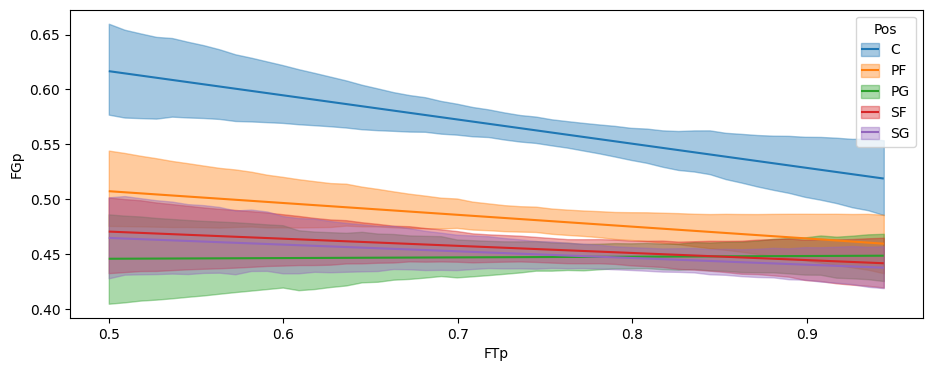

In [10]:
bmb.interpret.plot_predictions(model_basketball_h,
                               idata_basketball_h,
                               ["FTp","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

###predictors free throw percentage and position (with position interacting with frew throw percentage)

In [13]:
#define the model; bb_inter stands for baskeball interaction
model_bb_inter = bmb.Model("`FGp` ~ `FTp` + Pos + `FTp`:Pos", data=bb)
#create the model
idata_bb_inter = model_bb_inter.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FTp', ylabel='FGp'>], dtype=object))

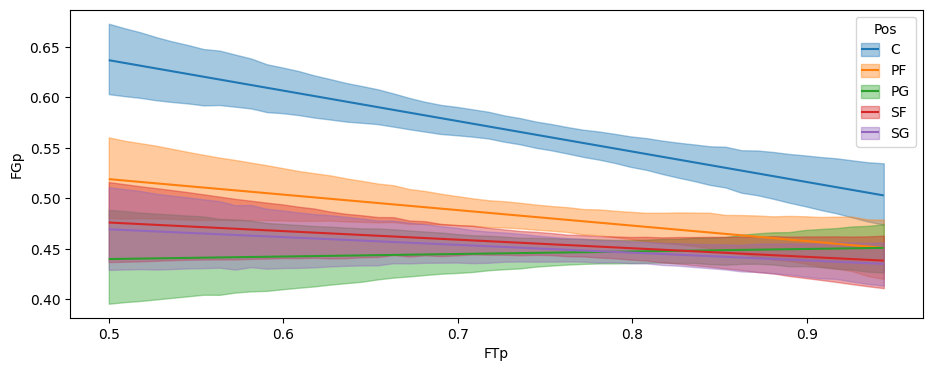

In [14]:
bmb.interpret.plot_predictions(model_bb_inter,
                               idata_bb_inter,
                               ["FTp","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

###predictors free throw percentage, position, 3 point attempts, and interactions between all three predictors



In [15]:
#define the model; bb_inter_3 stands for baskeball interaction with 3 predictors
model_bb_inter_3 = bmb.Model("`FGp` ~ `FTp` + Pos + `3PA` + `FTp`:Pos + Pos:`3PA` + FTp`3PA`", data=bb)
#create the model
idata_bb_inter_3 = model_bb_inter_3.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='3PA', ylabel='FGp'>], dtype=object))

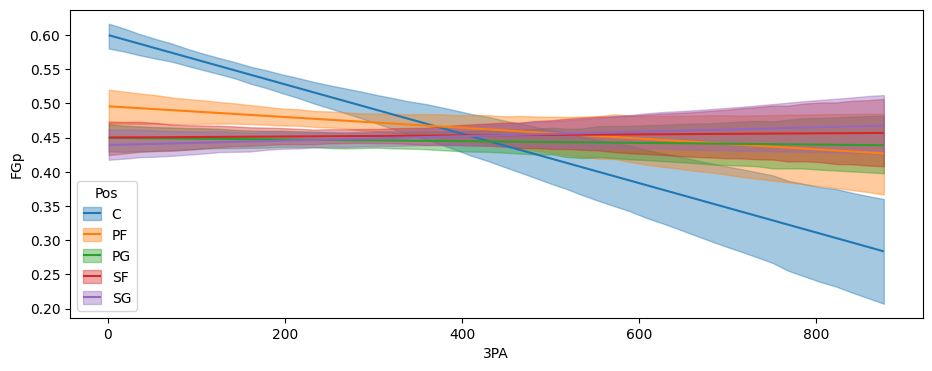

In [16]:
bmb.interpret.plot_predictions(model_bb_inter_3,
                               idata_bb_inter_3,
                               ["3PA","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FTp', ylabel='FGp'>], dtype=object))

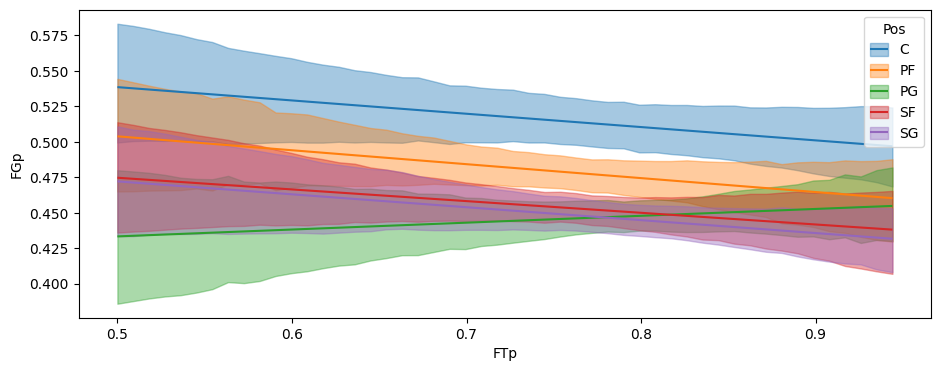

In [17]:
bmb.interpret.plot_predictions(model_bb_inter_3,
                               idata_bb_inter_3,
                               ["FTp","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

###predictors free throw percentage, position, 3 point attempts, with an interaction between 3 point attempts and postion.

In [26]:
#define the model; bb_inter_pos_3 stands for baskeball interaction between position and 3point attempts
model_bb_inter_pos_3 = bmb.Model("`FGp` ~ (`FTp` + `3PA` + `Pos`:`3PA`|`Pos`)", data=bb)
#create the model
idata_bb_inter_pos_3 = model_bb_inter_pos_3.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 151 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='3PA', ylabel='FGp'>], dtype=object))

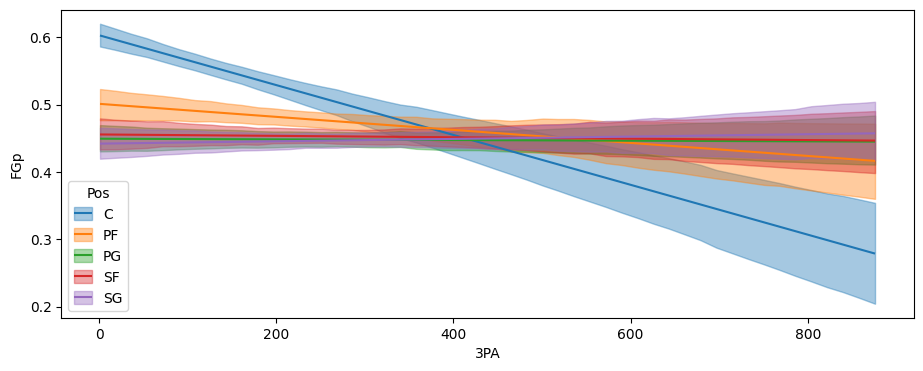

In [27]:
bmb.interpret.plot_predictions(model_bb_inter_pos_3,
                               idata_bb_inter_pos_3,
                               ["3PA","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FTp', ylabel='FGp'>], dtype=object))

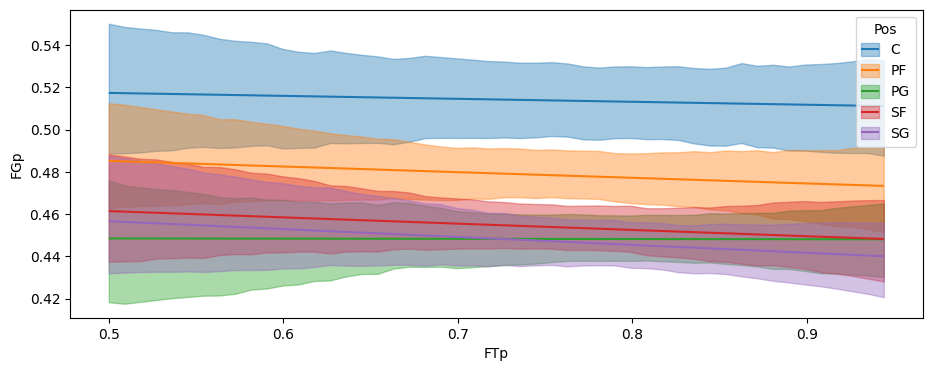

In [28]:
bmb.interpret.plot_predictions(model_bb_inter_pos_3,
                               idata_bb_inter_pos_3,
                               ["FTp","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FTp', ylabel='FGp'>], dtype=object))

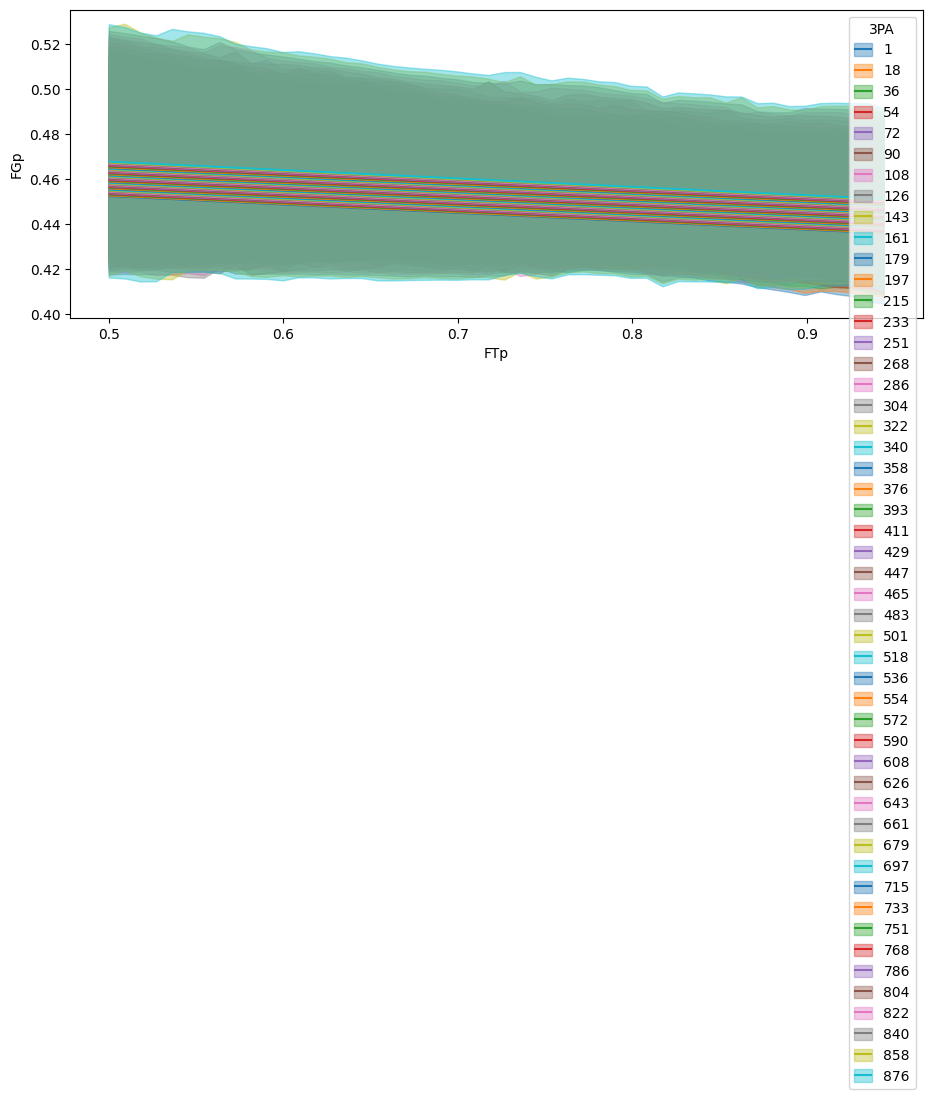

In [29]:
bmb.interpret.plot_predictions(model_bb_inter_pos_3,
                               idata_bb_inter_pos_3,
                               ["FTp","3PA"],
                               fig_kwargs={"figsize":(11, 4)})

###analysis

In [30]:
#cmp_df stands for compare dataframe
cmp_df = az.compare( {"FTp & Pos(cat)":idata_basketball,"FTp & Pos(hier)":idata_basketball_h,"FTp & Pos (inter)":idata_bb_inter,"FTp, Pos, & 3PA (inter all)":idata_bb_inter_3,"FTp, Pos, & 3PA (inter pos, 3pa)":idata_bb_inter_pos_3} )

#0 is the best rank; we want a lower elpd_loo
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
"FTp, Pos, & 3PA (inter pos, 3pa)",0,528.172566,13.901445,0.000000,8.921785e-01,16.366495,0.000000,False,log
"FTp, Pos, & 3PA (inter all)",1,526.448213,17.707254,1.724353,5.855622e-02,15.799195,2.265525,False,log
FTp & Pos (inter),2,508.635789,14.690043,19.536777,4.926526e-02,16.833632,8.213437,False,log
FTp & Pos(hier),3,508.233064,13.829523,19.939502,3.088418e-14,17.038985,7.286455,False,log
FTp & Pos(cat),4,507.265710,8.386964,20.906856,0.000000e+00,16.082869,7.011257,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

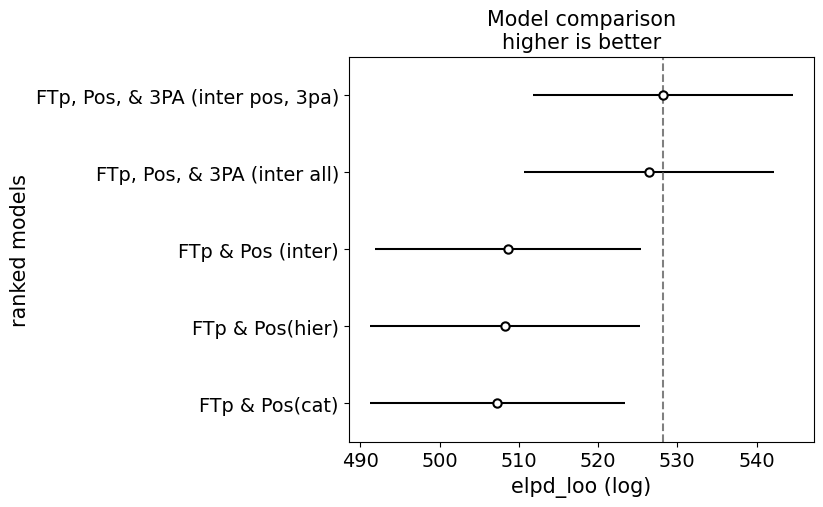

In [31]:
az.plot_compare(cmp_df)

##**Task11**:

Which model is "better" according to this metric?

Why do you think that is?

According to this the model with free throw percent, position, and three point attempts that only relates 3pa and pos is the best. I think this makes sense, because if we make a causal diagram of our inputs/outputs, I think we see that 3pa and ftp aren't very related, and ftp and pos aren't related. From my limited knowledge of basketball, this is what I assume. 3pa and pos are more closely related, because different positions do different things on the field (driving in close to hoop, three pointers, mid range 2 point shots etc).